In [2]:
from scipy.io import loadmat
from scipy.io import wavfile
import librosa
import librosa.display
import IPython
import matplotlib.pyplot as plt
import sounddevice as sd # only needed for playing
import soundfile as sf # only needed if playing does not work
import scipy.linalg as linalg
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import lfilter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def convmtx(h, n):
    '''
    Convolution matrix, same as convmtx does in matlab
    '''
    return linalg.toeplitz(
        np.hstack([h, np.zeros(n-1)]),
        np.hstack([h[0], np.zeros(n-1)]),
    )

In [4]:
# Input
#     x: input signal
#     y: desired signal
#     L: filter length
#     mu: step size
# Output
#     yhat: filter output
#     e: error per point   

def lms(x, y, L, mu):
    N = y.shape[0]
    w = np.zeros(L,)
    yhat = np.zeros(N,)
    e = np.zeros(N,)

    # zero-pad input signal
    x = np.concatenate((np.zeros(L-1,), x), axis=0)

    for n in range(0, N):
        x_n = x[n:n+L]
        yhat[n] = w.T @ x_n
        e[n] = y[n] - yhat[n]
        w = w + mu*e[n]*x_n
        
    return yhat, e

In [5]:
def mse(xhat, x):
    # MSE Compute the (optimally scaled) mean squared error
    # between a (noisy) signal estimate and an original (noise free) signal
    #          _              _
    #         |             2  |
    # e = min | (x - a*xhat)   |
    #      a  |_              _|
    #
    # Usage
    #    e = mse(xhat, x);
    #
    # Inputs
    #    xhat    Estimated signal
    #    x       Original signal
    # 
    # Outputs
    #    e       Mean squared error
    a = (x.T @ xhat) / (xhat.T @ xhat)
    e = np.mean((x-a*xhat)**2)
    return e

In [6]:
# Input
#     x: input signal
#     y: desired signal
#     L: filter length
#     mu: step size
#
# Output
#     yhat: filter output
def nlms(x, y, L, mu, delta):
    N = y.shape[0]
    w = np.zeros(L,)
    yhat = np.zeros(N,)
    e = np.zeros(N,)

    # if x is a one-dimensional vector we assume x is a time series and we
    # create X accordingly using X = convmtx(x, L), otherwise we assume it
    # already is a convolution matrix
    if x.ndim == 1:
        X = convmtx(x, L).T
    else:
        X = x

    for n in range(0, N):
        x_n = X[:,n]
        yhat[n] = w.T @ x_n
        e[n] = y[n] - yhat[n]
        w = w + (mu / (delta+x_n.T@x_n)) * x_n * e[n]
        
    return yhat, e

In [7]:
def rls(x, y, L, beta, lambda_):
    '''
    Input
        x: input signal
        y: desired signal
        L: filter length
        beta: forget factor
        lambda_: regularization

    Output
        yhat: filter output
    '''
    # reserve mem
    yhat = np.zeros(len(y))
    e = np.zeros(len(y))

    # if x is a one-dimensional vector we assume x is a time series and we
    # create X accordingly using X = convmtx(x, L), otherwise we assume it
    # already is a convolution matrix
    if x.ndim == 1:
        X = np.fliplr(convmtx(x,L)).T
    else:
        X = x

    # start RLS
    # initialize
    w = np.zeros(L)  # theta in the book
    w = np.expand_dims(w, -1)
    P = 1/lambda_*np.eye(L)

    # for each n do
    for n in range(len(y)):
        # get x_n
        x_n = X[:,n]
        x_n = np.expand_dims(x_n, -1)

        # get filter output
        yhat[n] = w.T@x_n

        # update iteration
        e[n] = y[n] - yhat[n]
        denum = beta + x_n.T@P@x_n
        K_n = (P@x_n)/denum
        w = w + K_n*e[n]
        P = (P - (K_n @ x_n.T) @ P)/beta

    return yhat, e

<h1>Store the audio to wav files<h1>

In [8]:
#Load our souds files
data_speech = loadmat('/Users/luchengliang/ML_sp/Assignment/problem_set_2_data/problem2_7_speech.mat')
data_bpir = loadmat('/Users/luchengliang/ML_sp/Assignment/problem_set_2_data/problem2_7_bpir.mat')
data_hpir = loadmat('/Users/luchengliang/ML_sp/Assignment/problem_set_2_data/problem2_7_hpir.mat')
data_lpir = loadmat('/Users/luchengliang/ML_sp/Assignment/problem_set_2_data/problem2_7_lpir.mat')

speech_signal = data_speech['speech']
bpir_signal = data_bpir['bpir']
hpir_signal = data_hpir['hpir']
lpir_signal = data_lpir['lpir']

if speech_signal.ndim > 1:
    speech_signal = np.squeeze(speech_signal)
if bpir_signal.ndim > 1:
    bpir_signal = np.squeeze(bpir_signal)
if hpir_signal.ndim > 1:
    hpir_signal = np.squeeze(hpir_signal)
if lpir_signal.ndim > 1:
    lpir_signal = np.squeeze(lpir_signal)    


sampling_rate = 8000

sf.write('speech.wav', speech_signal, sampling_rate, subtype='PCM_24')
sf.write('bpir.wav', bpir_signal, sampling_rate, subtype='PCM_24')
sf.write('hpir.wav', hpir_signal, sampling_rate, subtype='PCM_24')
sf.write('lpir.wav', lpir_signal, sampling_rate, subtype='PCM_24')

In [9]:
#Generate the noise
duration = 5 #noise, how much seconds
variance = 0.1 # modify the amplifier of noise

# Generate the random noise (mean=0, variance=1)
noise = np.random.randn(int(sampling_rate * duration))

scaled_noise = np.sqrt(variance) * noise
sf.write('noise.wav', scaled_noise, sampling_rate, subtype='PCM_24')

In [10]:
def Filter_the_original_speech(noise_s, mixed_s, name, adaptive_algo):
    
    # Load audio files
    x, Fs = librosa.load(noise_s, sr=8000)
    y, Fs = librosa.load(mixed_s, sr=8000)

    # Filter Length
    L = 100
    
    # parameters for lms 
    mu_lms = 0.5  # step size

    # parameters for nlms
    mu_nlms = 0.2  # normalized step-size
    delta = 1e-2  # regularization parameter

    # parameters for rls
    beta = 0.997  # forget factor
    lambda_ = 1e2  # regularization

    # Switch between adaptive algorithms
    if adaptive_algo == 'lms':
        yhat, _ = lms(x, y, L, mu_lms)
    elif adaptive_algo == 'nlms':
        yhat, _ = nlms(x, y, L, mu_nlms, delta)
    elif adaptive_algo == 'rls':
        yhat, _ = rls(x, y, L, beta, lambda_)

    # Plot the spectrograms of the signals
    # noisy speech
    spec_y = librosa.stft(y, n_fft=512, hop_length=32, center=True)
    y_db = librosa.amplitude_to_db(abs(spec_y))
    plt.figure(figsize=(14, 3))
    plt.title("MIXED SIGNAL(SPEECH)")
    librosa.display.specshow(y_db, sr=Fs)

    # noise
    spec_x = librosa.stft(x, n_fft=512, hop_length=32, center=True)
    x_db = librosa.amplitude_to_db(abs(spec_x))
    plt.figure(figsize=(14, 3))
    plt.title("NOISE")
    librosa.display.specshow(x_db, sr=Fs)

    # filter output
    spec_yhat = librosa.stft(y-yhat, n_fft=512, hop_length=32, center=True)
    yhat_db = librosa.amplitude_to_db(abs(spec_yhat))
    plt.figure(figsize=(14, 3))
    plt.title("FILTER ERROR SIGNAL")
    librosa.display.specshow(yhat_db, sr=Fs)

    plt.show()

    # Play filter output
    # sd.play(y-yhat, Fs)
    # if you cannot get the sounddevice to play, use this line to write the file to wav instead
    sf.write('filter_output_{0}({1}).wav'.format(name, adaptive_algo), y-yhat, Fs, subtype='PCM_24')

    # read original speech without noise
    o, Fs = librosa.load('speech.wav', sr=8000)

    # Compute MSE, by comparing original speech to output from algorithm, so enhanced speech
    e = mse(y-yhat, o)
    print('Mean squared error: ', e)

<h1>Mix the audio<h1>

In [11]:
# Load the speech signal and the noise signal
speech_signal, Fs = librosa.load('speech.wav', sr=8000)
noise_signal, Fs = librosa.load('noise.wav', sr=8000)

if len(noise_signal) != len(speech_signal):
    noise_signal = noise_signal[:len(speech_signal)]

In [12]:
# Filter the noise signal using the filter coefficients
filtered_noise_signal_bpir = lfilter(bpir_signal, [1.0], noise_signal)
filtered_noise_signal_hpir = lfilter(hpir_signal, [1.0], noise_signal)
filtered_noise_signal_lpir = lfilter(lpir_signal, [1.0], noise_signal)

# Adjust the scaling of the filtered noise to control its intensity
desired_snr_db = 5  # Adjust the desired Signal-to-Noise Ratio (SNR) in dB
speech_power = np.mean(speech_signal ** 2)

#bpir part
noise_power_bpir = np.mean(filtered_noise_signal_bpir ** 2)
noise_scaling_bpir = np.sqrt(speech_power / (noise_power_bpir * 10 ** (desired_snr_db / 10)))
scaled_filtered_noise_bpir = filtered_noise_signal_bpir * noise_scaling_bpir

#hpir part
noise_power_hpir = np.mean(filtered_noise_signal_hpir ** 2)
noise_scaling_hpir = np.sqrt(speech_power / (noise_power_hpir * 10 ** (desired_snr_db / 10)))
scaled_filtered_noise_hpir = filtered_noise_signal_hpir * noise_scaling_hpir

#lpir part
noise_power_lpir = np.mean(filtered_noise_signal_lpir ** 2)
noise_scaling_lpir = np.sqrt(speech_power / (noise_power_lpir * 10 ** (desired_snr_db / 10)))
scaled_filtered_noise_lpir = filtered_noise_signal_lpir * noise_scaling_lpir

# Mix the speech and filtered noise signals
mixed_signal_bpir = speech_signal + scaled_filtered_noise_bpir
mixed_signal_hpir = speech_signal + scaled_filtered_noise_hpir
mixed_signal_lpir = speech_signal + scaled_filtered_noise_lpir

# Save the mixed signal as a WAV file
sf.write('mixed_signal_bpir_filter.wav', mixed_signal_bpir, sampling_rate, subtype='PCM_24')
sf.write('mixed_signal_hpir_filter.wav', mixed_signal_hpir, sampling_rate, subtype='PCM_24')
sf.write('mixed_signal_lpir_filter.wav', mixed_signal_lpir, sampling_rate, subtype='PCM_24')

<h1>For Mixed signal: Speech + bpir + Noise<h1>

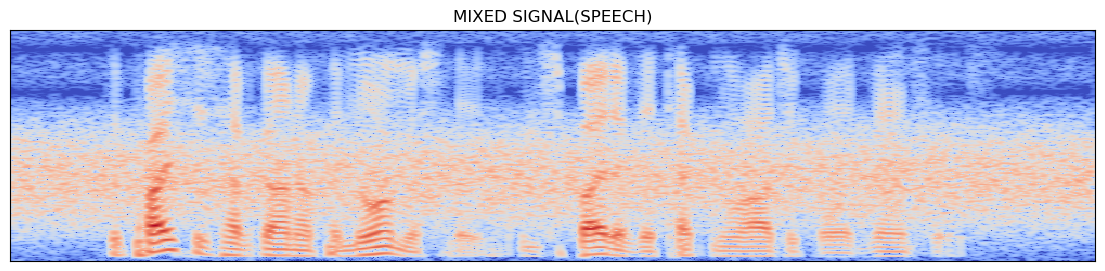

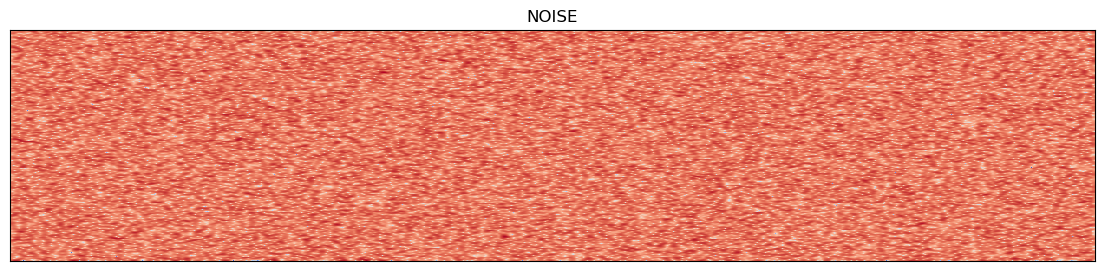

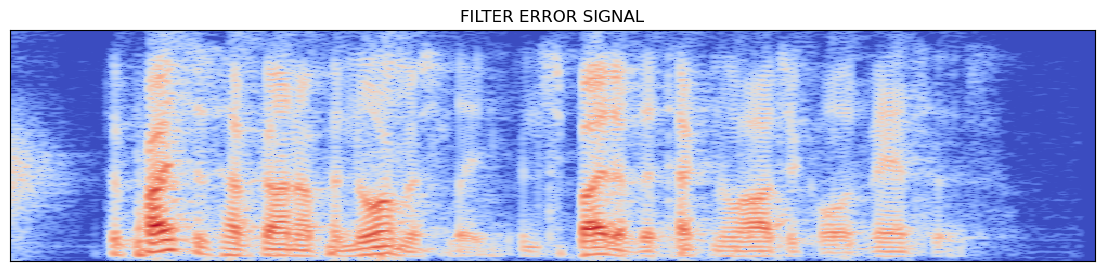

Mean squared error:  0.0001850263056683933


In [17]:
mixed_s = 'mixed_signal_bpir_filter.wav'
noise_s = 'noise.wav'
name = 'bpir'
#Chose one of adative algorithm: lms, nlms, rls
alogrithm = 'nlms'

Filter_the_original_speech(noise_s, mixed_s, name, alogrithm)

<h1>For Mixed signal: Speech + hpir + Noise<h1>

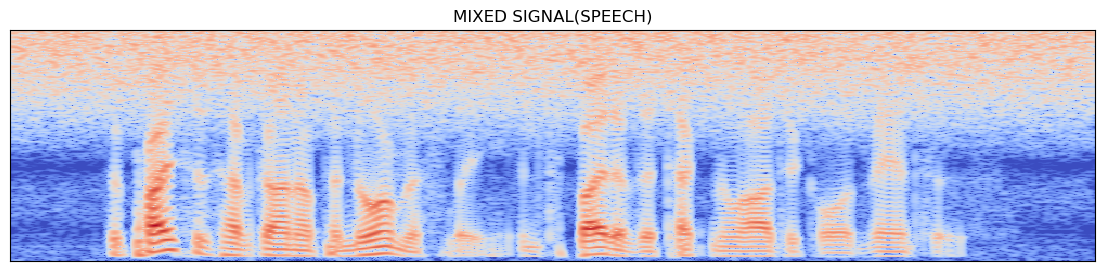

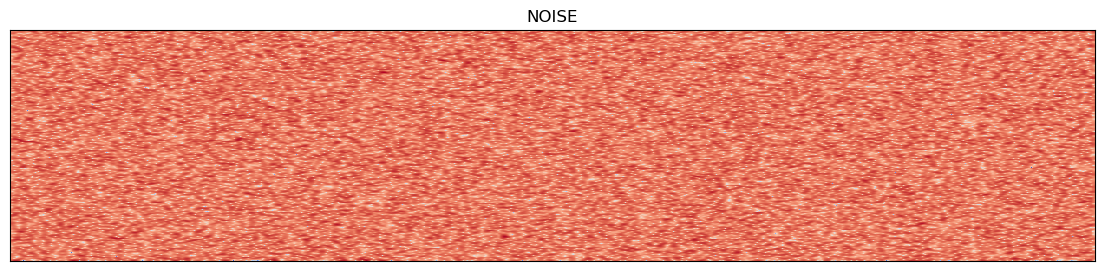

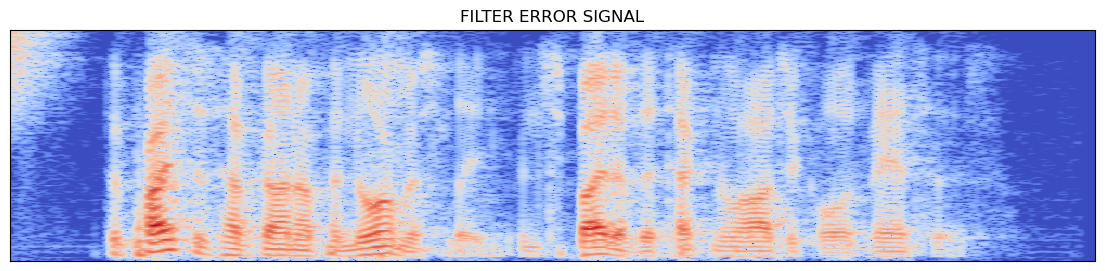

Mean squared error:  0.000186171580027937


In [21]:
mixed_s = 'mixed_signal_hpir_filter.wav'
noise_s = 'noise.wav'
name = 'hpir'
#Chose one of adative algorithm: lms, nlms, rls
alogrithm = 'nlms'

Filter_the_original_speech(noise_s, mixed_s, name, alogrithm)

<h1>For Mixed signal: Speech + lpir + Noise<h1>

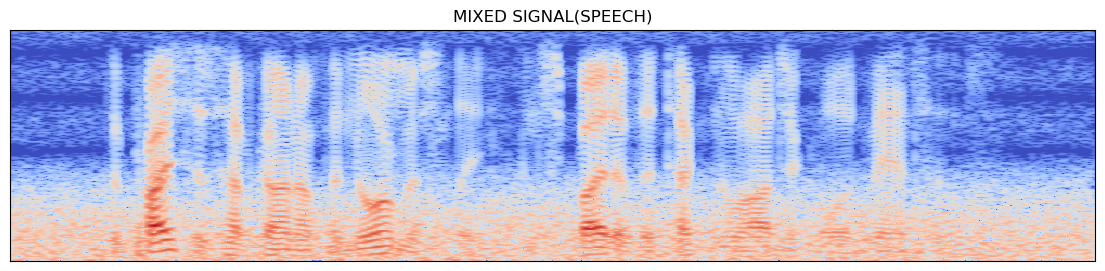

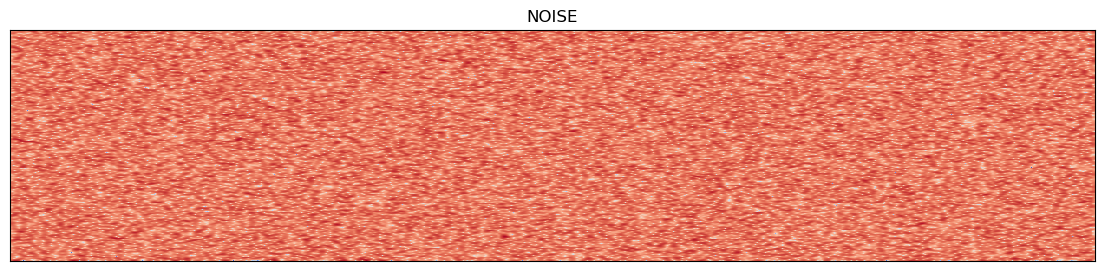

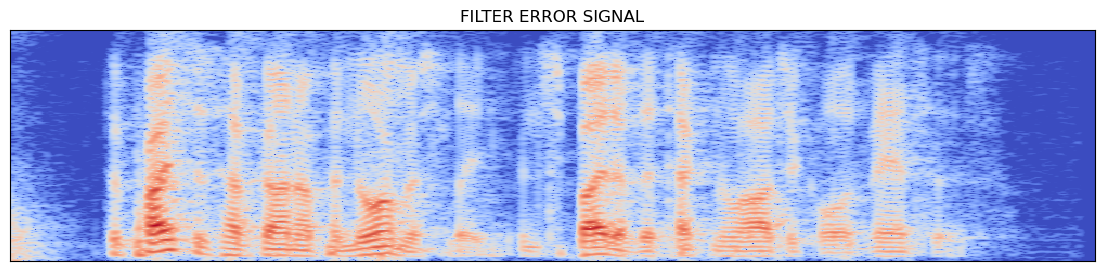

Mean squared error:  0.00018529338033760893


In [19]:
mixed_s = 'mixed_signal_lpir_filter.wav'
noise_s = 'noise.wav'
name = 'lpir'
#Chose one of adative algorithm: lms, nlms, rls
alogrithm = 'nlms'

Filter_the_original_speech(noise_s, mixed_s, name, alogrithm)